In [ ]:
%%html
<style>
table {float:center}
</style>

In [26]:
import os
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm


PATH_DIR_DATA = "data"
PATH_DATA = os.path.join(PATH_DIR_DATA, "CTR.txt")

# Chargement des données 

In [23]:
df = pd.read_csv(PATH_DATA, sep=":", header=None)
df.iloc[:, 1] = df.iloc[:, 1].apply(lambda l: list(map(float, l.split(';'))))
df.iloc[:, 2] = df.iloc[:, 2].apply(lambda l: list(map(float, l.split(';'))))
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
0    5000 non-null int64
1    5000 non-null object
2    5000 non-null object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB
None


,0,1,2
0,0,"[0.74837091377052, 0.8352077827766918, 0.07669...","[0.10341905704918021, 0.19069778281037159, 0.0..."
1,1,"[0.16841851887985582, 0.1337544632704264, 0.43...","[0.0, 0.0, 0.0, 0.020827097947315257, 0.0, 0.0..."
2,2,"[0.4852873193263283, 0.5669886866963504, 0.041...","[0.10957461446818696, 0.13662644655693568, 0.0..."
3,3,"[0.6222307845696199, 0.1961234321879859, 0.131...","[0.0, 0.1510688622593973, 0.0, 0.1272393919522..."
4,4,"[0.3317104123038488, 0.08641097481469784, 0.02...","[0.0, 0.10921436423915529, 0.0, 0.151937820362..."


# Stratégies baselines

In [29]:
def strategie_random(df, num_article):
        """ Pour un num_article donné, renvoie un annonceur aléatoirement """
        return randint(0, 9)


def strategie_staticbest(df, num_article):
    """ Pour un num_article donné, renvoie l'annonceur avec le meilleur 
    taux de clics cumulés
    """
    return np.array(df.iloc[:, 2].values.tolist()).sum(axis=0).argmax()


def strategie_optimale(df, num_article):
    """ Pour un num_article donné, renvoie l'annonceur qui a le meilleur
    taux de clics pour ce num_article
    """
    return np.argmax(df.iloc[num_article, 2])


def baseline(df, strategie, T=5000, verbose=True):
    """ Permet de d'obtenir la liste des rewards cumulés à l'itération t
    pour une stratégie définie.
    """
    total_reward = [df.iloc[0,2][strategie(df, 0)]]
    for i in tqdm(range(1, T), disable=not verbose):
        total_reward.append(total_reward[-1] + df.iloc[i,2][strategie(df, i)])
    return total_reward

# Algorithme UCB

In [30]:
def ucb(df, T=5000, verbose=True): 
    """ Renvoie la liste des rewards cumulés à l'itération t
    pour la méthode UCB.
    """
    # Initialisation
    B = np.zeros(10)
    somme_reward = [[] for _ in range(10)]
    total_reward = []
    somme_reward[0].append(df.iloc[0, 2][0])
    total_reward.append(df.iloc[0, 2][0])
    B[0] = np.sqrt(2 * np.log(1))
    for t in range(1, 10):
        somme_reward[t].append(df.iloc[t, 2][t])
        total_reward.append(total_reward[-1] + df.iloc[t, 2][t])
        B[t] = np.sqrt(2 * np.log(t+1))

    for t in tqdm(range(10, T), initial=10, disable=not verbose):
        pi_t = B.argmax()
        somme_reward[pi_t].append(df.iloc[t, 2][pi_t])
        total_reward.append(total_reward[-1] + df.iloc[t, 2][pi_t])
        B[pi_t] = np.mean(somme_reward[pi_t]) + np.sqrt(2 * np.log(t+1) /\
                                                len(somme_reward[pi_t]))
        
    return total_reward

# Algorithme LinUCB

In [31]:
def LinUCB(df, alpha, T=5000, verbose=True):
    """ Renvoie la liste des rewards cumulés à l'itération t
    pour la méthode LinUCB.
    """
    features = df.iloc[:, 1].values
    d = len(features[0])
    theta, p = [None] * 10, np.zeros(10)
    A, B = [None] * 10, [None] * 10
    total_reward = []
    for t in tqdm(range(T), disable=not verbose):
        for a in range(10):
            if A[a] is None:
                A[a] = np.identity(d)
                B[a] = np.zeros(d)
            A_inverse = np.linalg.inv(A[a])
            theta[a] = A_inverse @ B[a]
            p[a] = np.transpose(theta[a]) @ features[t] + alpha *\
                   np.sqrt(np.transpose(features[t]) @ A_inverse @ \
                   features[t])
        a_t = p.argmax()
        if len(total_reward) == 0:
            total_reward.append(df.iloc[t, 2][a_t])
        else:
            total_reward.append(total_reward[-1] + df.iloc[t, 2][a_t])
          
        A[a_t] += features[t] @ np.transpose(features[t])
        B[a_t] += df.iloc[t, 2][a_t] * np.array(features[t])
    return total_reward

### Recherche d' $\alpha$ optimal

In [40]:
def get_best_alpha(df, T=5000, nb_step_alpha=20, verbose=True):
    """ Permet de tester differents alphas pour la fonction LinUCB
    et d'afficher un graphique pour les comparers.
    Renvoie un tuble contenant le meilleur alpha et le
    reward cumulé final pour cet alpha.
    """
    alpha = 0.1
    best = [0.1, 0]
    x = [i for i in range(T)]
    for _ in tqdm(range(nb_step_alpha), disable=not verbose):
        total_reward = LinUCB(df, alpha, T, verbose=False)
        if verbose:
            print("alpha =", alpha, "---> r =", total_reward[-1])
        if best[1] < total_reward[-1]:
            best[0] = alpha
            best[1] = total_reward[-1]
        
        plt.plot(x, total_reward, label=r"$\alpha$ = "+str(round(alpha, 1)))
        alpha += 0.1
    plt.legend()
    plt.xlabel("Itération")
    plt.ylabel("Reward cumulé")
    titre = """
    Graphique pour LinUCB du reward cumulé en fonction du nombre d'itérations
    pour différentes valeurs de alpha
    """
    plt.title(titre)
    plt.plot()
    return tuple(best)


  0%|                                                | 0/10 [00:00<?, ?it/s]

alpha = 0.1 ---> r = 1241.698785846658



 10%|████                                    | 1/10 [00:16<02:24, 16.03s/it]

alpha = 0.2 ---> r = 1210.875088704047



 20%|████████                                | 2/10 [00:31<02:06, 15.77s/it]

alpha = 0.30000000000000004 ---> r = 1248.1251938335824



 30%|████████████                            | 3/10 [00:46<01:49, 15.63s/it]

alpha = 0.4 ---> r = 1245.4267254017004



 40%|████████████████                        | 4/10 [01:01<01:33, 15.53s/it]

alpha = 0.5 ---> r = 1254.3912945262732



 50%|████████████████████                    | 5/10 [01:18<01:19, 15.90s/it]

alpha = 0.6 ---> r = 1249.816817229307



 60%|████████████████████████                | 6/10 [01:34<01:03, 15.85s/it]

alpha = 0.7 ---> r = 1108.3258306411242



 70%|████████████████████████████            | 7/10 [01:50<00:48, 16.06s/it]

alpha = 0.7999999999999999 ---> r = 1106.9254520644215



 80%|████████████████████████████████        | 8/10 [02:07<00:32, 16.20s/it]

alpha = 0.8999999999999999 ---> r = 1175.9891308156825



 90%|████████████████████████████████████    | 9/10 [02:23<00:16, 16.25s/it]

alpha = 0.9999999999999999 ---> r = 1174.094688355015



100%|███████████████████████████████████████| 10/10 [02:40<00:00, 16.37s/it]


(0.5, 1254.3912945262732)

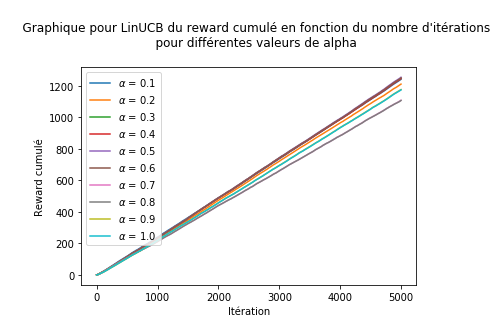

In [42]:
get_best_alpha(df, T=5000, nb_step_alpha=10)

Nous trouvons que le meilleur $\alpha$ est 0.5.  
Nous avons testé des valeurs de $\alpha$ allant de 0.1 à 2 avec un pas de 0.1.  
Le graphique ci-dessus ne montre que les $\alpha$ de 0.1 à 1 pour des raisons esthetiques.

# Bonus: UCB-V

In [163]:
def ucb_v(df, T=5000, verbose=True):
    """ Renvoie la liste des rewards cumulés à l'itération t
    pour la méthode UCB-V.
    """
    B = np.zeros(10)
    somme_reward = [[] for _ in range(10)]
    variance_reward = [[] for _ in range(10)]

    total_reward = []
    # Initialisation
    somme_reward[0].append(df.iloc[0, 2][0])
    variance_reward[0].append(0)
    total_reward.append(df.iloc[0, 2][0])
    B[0] = np.sqrt(2 * np.log(1))
    for t in range(1, 10):
        somme_reward[t].append(df.iloc[t, 2][t])
        variance_reward[t].append(0)
        total_reward.append(total_reward[-1] + df.iloc[t, 2][t])
        B[t] = np.sqrt(2 * np.log(t+1))

    for t in tqdm(range(10, T), initial=10, disable=not verbose):
        pi_t = B.argmax()
        somme_reward[pi_t].append(df.iloc[t, 2][pi_t])
        moyenne = np.mean(somme_reward[pi_t])
        somme = np.sum(np.array(somme_reward[pi_t]) - moyenne)**2
        variance_reward[pi_t] = somme / len(somme_reward[pi_t])
        total_reward.append(total_reward[-1] + df.iloc[t, 2][pi_t])
        
        B[pi_t] = moyenne + np.sqrt(2 * np.log(t+1) * variance_reward[pi_t]/\
                  len(somme_reward[pi_t])) + np.log(t+1) /\
                  (2 * len(somme_reward[pi_t]))
        
    return total_reward

# Comparaison des méthodes

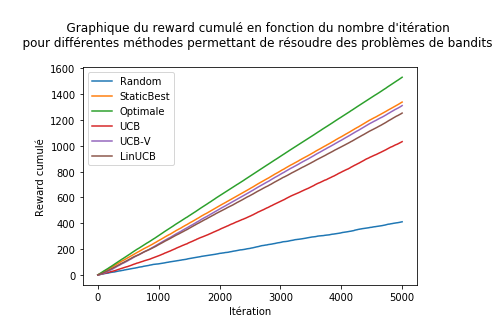

In [186]:
def plot_graph(df, T=5000):
    """ Affiche du graphique représentant le reward cumulé à
    l'itération t pour différentes méthodes"""
    x = [i for i in range(T)]
    plt.plot(x, baseline(df, strategie_random, T), label="Random" )
    plt.plot(x, baseline(df, strategie_staticbest, T), label="StaticBest")
    plt.plot(x, baseline(df, strategie_optimale, T), label="Optimale")
    plt.plot(x, ucb(df, T), label="UCB")
    plt.plot(x, ucb_v(df, T), label="UCB-V")
    plt.plot(x, LinUCB(df, 0.5, T), label="LinUCB")
    plt.legend()
    plt.xlabel("Itération")
    plt.ylabel("Reward cumulé")
    titre = """
    Graphique du reward cumulé en fonction du nombre d'itération
    pour différentes méthodes permettant de résoudre des problèmes de bandits
    """
    plt.title(titre)
    plt.show()
    
plot_graph(df)

On trouve bien des résultats cohérents, la méthode random donne bien, et de loin, les plus mauvais résultats tandis que l'optimal lui donne les meilleurs. De plus LinUCB et UCB-V étant des améliorations de UCB, on retrouve bien de meilleurs résultats que UCB.
Pour finir si l'on regarde bien UCB, on remarque que nous n'avons pas rééllement qu'une droite mais que de 0 à 1000 nous avons une progressions lineaire, puis de 1000 à 5000 une autre différente, laissant présager une amélioration.

Maintenant nous trouvons étrange que UCB-V soit meilleur que LinUCB et que StaticBest soit la deuxième meilleure méthode même si UCB-V et lui sont quasiment égaux.